# 보스톤 집값 예측

## 패키지 로딩

In [45]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import pandas as pd

## 데이터 로드 및 확인
- CRIM: 범죄율
- ZN: 25,000평방피트를 초과하는 거주 지역 비율
- INDUS: 상업 지역 면적 비율
- CHAS: 찰스강 경계 위치
- NOX: 일산화질소 농도
- RM: 주택당 방 수
- AGE: 주택 연령
- DIS: 직업 센터까지 거리
- RAD: 고속도로까지의 거리
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 인구 중 흑인 비율
- LSTAT: 인구 중 하위 계층 비율
- MEDV: 주택 가격(종속변수)

In [30]:
df = pd.read_csv('HousingData.csv')
display(df.head())

# df.dropna(inplace=True)

x = df.drop('MEDV', axis=1)
y = df['MEDV']

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [21]:
print(df.isna().sum())

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


## 결측치 처리

In [17]:
print(df.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  486.000000  486.000000  486.000000  486.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.720192   23.388876    6.835896    0.255340    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.081900    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.560263   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  486.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.518519    3.795043    9.549407  408.237154   18.455534  356.674032   
std     27.999513    2.1057

## 학습/퍙기 데이터 분할

### 스케일링 된 데이터 분할

In [31]:
scaled_data = StandardScaler().fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, test_size=0.3, random_state=10)

### 스케일링 안 된 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)

## 알파값 변화에 따른 회귀계수 및 상관계수 값 계산
- 알파값은 규제 강도를 제어하는 상수로 [0,inf) 범위의 부동 소수점 값을 사용할 수 있다.
- alpha=0 이면, LinearRegression에서 사용되는 일반적인 최소제곱법과 같아진다. (규제 적용 X)

In [24]:
def regulation_compare(alpha, model_name):     # alpha 값 변화에 따른 회귀모형 weight의 변화
    df = pd.DataFrame()
    for a in alpha:
        print('회귀모형:', model_name)
        print('알파값:', a)

        if model_name == 'Lasso':
            model = Lasso(alpha=a)
        elif model_name == 'Ridge':
            model = Ridge(alpha=a)
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha=a, l1_ratio=0.5)   # L1, L2 사용 비율 정해야 함

        model.fit(x_train, y_train)   # 학습
        r_square = model.score(x_test, y_test)
        print(f'결정계수:{r_square:.2f}')
        weight = { f:w for f,w in zip(x.columns, model.coef_) }
        y_hat = model.predict(x_test)
        print(f'RMSE:{np.sqrt(mean_squared_error(y_test, y_hat))}')
        print('-'*20)

        df['alpha='+str(a)] = pd.Series(weight)
    
    return df

## 라쏘 회귀모델 생성 (L1 규제)

In [35]:
# 알파값이 커질수록 제거되는 항이 많아지면서 결정계수의 값이 낮아지는 결과를 보임
# 즉, 독립변수로 사용되는 14개의 특성 값이 집 값을 결정 짓는 주요한 역할을 하고 있는 것으로 판단된다.
alpha = [0, 0.07, 0.1, 0.5, 1, 3]     # L2보다 작은 aplha 값 = 크다면 가중치의 변화가 매우 커지기 때문
regulation_compare(alpha, 'Lasso')

회귀모형: Lasso
알파값: 0
결정계수:0.78
RMSE:3.4980311744456913
--------------------
회귀모형: Lasso
알파값: 0.07
결정계수:0.80
RMSE:3.3811192181458005
--------------------
회귀모형: Lasso
알파값: 0.1
결정계수:0.80
RMSE:3.3651717464359123
--------------------
회귀모형: Lasso
알파값: 0.5
결정계수:0.77
RMSE:3.59218864405574
--------------------
회귀모형: Lasso
알파값: 1
결정계수:0.74
RMSE:3.835333812806333
--------------------
회귀모형: Lasso
알파값: 3
결정계수:0.59
RMSE:4.82343520147051
--------------------


C:\Users\user\AppData\Local\Temp\ipykernel_27868\1006607766.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(x_train, y_train)   # 학습
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+03, tolerance: 2.611e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


,alpha=0,alpha=0.07,alpha=0.1,alpha=0.5,alpha=1,alpha=3
CRIM,-0.978682,-0.786561,-0.704372,-0.170294,-0.000000,-0.000000
ZN,1.266234,1.000006,0.886016,0.000000,0.000000,0.000000
INDUS,0.013387,-0.158579,-0.231884,-0.000000,-0.000000,-0.000000
CHAS,0.926120,0.910501,0.903754,0.616207,0.163113,0.000000
NOX,-2.519046,-2.196681,-2.058722,-0.427458,-0.000000,-0.000000
RM,2.616783,2.694049,2.727099,2.949034,2.760012,2.085371
AGE,-0.300481,-0.132180,-0.060047,-0.000000,-0.000000,-0.000000
DIS,-3.464894,-2.905007,-2.665093,-0.161514,-0.000000,0.000000
RAD,3.005857,1.884646,1.405225,-0.000000,-0.000000,-0.000000
TAX,-2.676262,-1.648546,-1.209126,-0.176253,-0.271523,-0.000000


## 릿지 회귀모델 생성 (L2 규제)

In [36]:
alpha = [0, 1, 5, 10, 100]    # L1 알파 값보다 큰 값 => weight에 비례한 값 빼기 때문
regulation_compare(alpha, 'Ridge')

회귀모형: Ridge
알파값: 0
결정계수:0.78
RMSE:3.4980311744456825
--------------------
회귀모형: Ridge
알파값: 1
결정계수:0.78
RMSE:3.4774417287658403
--------------------
회귀모형: Ridge
알파값: 5
결정계수:0.79
RMSE:3.4222435377551648
--------------------
회귀모형: Ridge
알파값: 10
결정계수:0.80
RMSE:3.3868391919538743
--------------------
회귀모형: Ridge
알파값: 100
결정계수:0.78
RMSE:3.5441420905441086
--------------------


,alpha=0,alpha=1,alpha=5,alpha=10,alpha=100
CRIM,-0.978682,-0.962117,-0.907500,-0.856741,-0.615249
ZN,1.266234,1.229297,1.111122,1.006092,0.568829
INDUS,0.013387,-0.046844,-0.222760,-0.355077,-0.609314
CHAS,0.926120,0.932566,0.949906,0.960291,0.878766
NOX,-2.519046,-2.456936,-2.240145,-2.022631,-0.829313
RM,2.616783,2.630885,2.675673,2.713414,2.606679
AGE,-0.300481,-0.300826,-0.302248,-0.303599,-0.297244
DIS,-3.464894,-3.399145,-3.163826,-2.917668,-1.237731
RAD,3.005857,2.842589,2.339628,1.918355,0.305239
TAX,-2.676262,-2.507840,-2.008382,-1.619346,-0.609589


## 엘라스틱 회귀모델 생성 (L1 + L2 규제)

In [37]:
alpha = [0, 1, 5, 10, 100]
regulation_compare(alpha, 'ElasticNet')

회귀모형: ElasticNet
알파값: 0
결정계수:0.78
RMSE:3.4980311744456913
--------------------
회귀모형: ElasticNet
알파값: 1
결정계수:0.72
RMSE:3.9286287709628214
--------------------
회귀모형: ElasticNet
알파값: 5
결정계수:0.41
RMSE:5.772068372838742
--------------------
회귀모형: ElasticNet
알파값: 10
결정계수:0.11
RMSE:7.074392354975468
--------------------
회귀모형: ElasticNet
알파값: 100
결정계수:-0.01
RMSE:7.544156569060303
--------------------


C:\Users\user\AppData\Local\Temp\ipykernel_27868\1006607766.py:14: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(x_train, y_train)   # 학습
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+03, tolerance: 2.611e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


,alpha=0,alpha=1,alpha=5,alpha=10,alpha=100
CRIM,-0.978682,-0.377179,-0.075963,-0.000000,-0.0
ZN,1.266234,0.159411,0.000000,0.000000,0.0
INDUS,0.013387,-0.400150,-0.251924,-0.000000,-0.0
CHAS,0.926120,0.543796,0.000000,0.000000,0.0
NOX,-2.519046,-0.364361,-0.124030,-0.000000,-0.0
RM,2.616783,2.414444,1.038461,0.373231,0.0
AGE,-0.300481,-0.000000,-0.000000,-0.000000,-0.0
DIS,-3.464894,-0.000000,0.000000,0.000000,0.0
RAD,3.005857,-0.000000,-0.061894,-0.000000,-0.0
TAX,-2.676262,-0.436769,-0.277347,-0.000000,-0.0


# [실습] 대한민국 육군 몸무게 예측
- 다음 3가지 회귀모형 결과 비교하기
>- 일반 선형회귀
>- L1 규제가 적용된 Lasso 모형(알파값:1)
>- L2 규제가 적용된 Ridge 모형(알파값:10)
>- 평가지표: 결정계수, MAE, RMSE

In [77]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import pandas as pd

## 데이터 로딩 및 확인

In [78]:
df = pd.read_csv('./dataset/Army-Dataset.csv')
print(df.shape)
print(df.info())
display(df.head())

(59996, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59996 entries, 0 to 59995
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Seq     59996 non-null  int64  
 1   Chest   59996 non-null  float64
 2   Height  59996 non-null  float64
 3   Waist   59996 non-null  float64
 4   Head    59996 non-null  float64
 5   Foot    59996 non-null  float64
 6   Weight  59996 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 3.2 MB
None


,Seq,Chest,Height,Waist,Head,Foot,Weight
0,1,96.3,185.5,82.5,57.1,28.5,73.2
1,2,101.9,167.2,81.2,55.0,24.2,65.1
2,3,99.5,179.9,99.2,56.3,28.1,93.2
3,4,98.6,171.4,85.9,54.5,27.4,71.6
4,5,94.7,176.9,78.3,58.5,26.5,67.1


In [61]:
df.drop('Seq', axis=1, inplace=True)

## 독립변수, 종속변수 분리

In [62]:
x = df.loc[:,'Chest':'Foot']
y = df['Weight']

## 학습, 평가 데이터 분리

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=10)

## 모델 생성 및 학습

In [65]:
linear = LinearRegression()
lasso = Lasso(alpha=1)
ridge = Ridge(alpha=10)

In [66]:
linear.fit(x_train, y_train)
lasso.fit(x_train, y_train)
ridge.fit(x_train, y_train)

Ridge(alpha=10)

## 예측 및 평가

In [76]:
linear_y_hat = linear.predict(x_test)
lasso_y_hat = lasso.predict(x_test)
ridge_y_hat = ridge.predict(x_test)

In [84]:
linear_r2 = linear.score(x_test, y_test)
lasso_r2 = lasso.score(x_test, y_test)
ridge_r2 = ridge.score(x_test, y_test)

linear_MSE = mean_squared_error(y_test, linear_y_hat)
lasso_MSE = mean_squared_error(y_test, lasso_y_hat)
ridge_MSE = mean_squared_error(y_test, ridge_y_hat)

linear_MAE = mean_absolute_error(y_test, linear_y_hat)
lasso_MAE = mean_absolute_error(y_test, lasso_y_hat)
ridge_MAE = mean_absolute_error(y_test, ridge_y_hat)

print(f'R2 Score: Linear:{linear_r2:.2f}, Lasso:{lasso_r2:.2f}, Ridge:{ridge_r2:.2f}')
print(f'MSE: Linear:{linear_MSE:.2f}, Lasso:{lasso_MSE:.2f}, Ridge:{ridge_MSE:.2f}')
print(f'MAE: Linear:{linear_MAE:.2f}, Lasso:{lasso_MAE:.2f}, Ridge:{ridge_MAE:.2f}')

R2 Score: Linear:0.89, Lasso:0.88, Ridge:0.89
MSE: Linear:21.98, Lasso:22.30, Ridge:21.98
MAE: Linear:3.54, Lasso:3.55, Ridge:3.54


## 알파값 변화에 다른 모델 성능 변화 시각화

In [87]:
ridge_result = []
lasso_result = []
alpha = [0.001, 0.01, 0.1, 1, 5, 7, 10, 30]

for a in alpha:
    ridge = Ridge(alpha=a)
    lasso = Lasso(alpha=a)

    ridge.fit(x_train, y_train)
    lasso.fit(x_train, y_train)

    ridge_r2 = ridge.score(x_test, y_test)
    lasso_r2 = lasso.score(x_test, y_test)
    ridge_result.append(ridge_r2)
    lasso_result.append(lasso_r2)

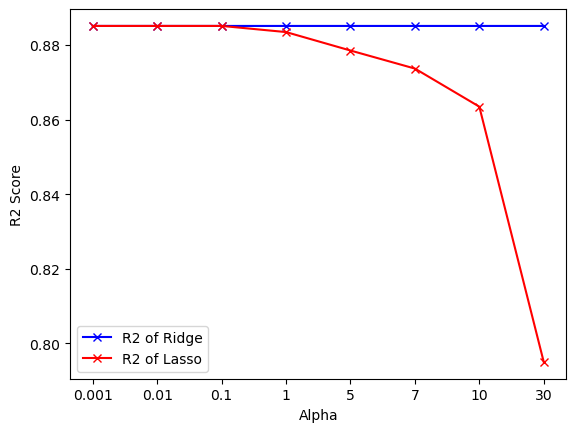

In [88]:
import matplotlib.pyplot as plt

plt.plot(range(len(alpha)), ridge_result, '-xb', label='R2 of Ridge')
plt.plot(range(len(alpha)), lasso_result, '-xr', label='R2 of Lasso')
plt.xticks(range(len(alpha)), alpha)
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.legend()
plt.show()

In [ ]:
score = cross_val_score(model, x, y)   # model = Decision~
print('score:', score)
print(f'평균 정확도:{np.mean(score):.2f}')